In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
keras = tf.keras
from keras import layers, callbacks
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
)
import pickle
import warnings
warnings.filterwarnings('ignore')

#random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

os.makedirs('results/figures', exist_ok=True)
os.makedirs('models', exist_ok=True)



In [29]:
from sklearn.model_selection import train_test_split

#neural network classifier
print("Neural network classifier")
print("="*60)

#load preprocessed data
print("Step 1: Loading preprocesses data")
print("="*60)

with open('models/preprocessed_data.pkl','rb') as f:
    preprocessed_data= pickle.load(f)

feature_names = preprocessed_data['feature_names']
X_train = preprocessed_data['X_train']
X_test = preprocessed_data['X_test']
y_train = preprocessed_data['y_train']
y_test= preprocessed_data['y_test']

X_train_fit, X_val, y_train_fit, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)


print("Data loaded successfully.")
print(f"Training samples: {X_train_fit.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Features: {X_train.shape[1]}")
print(f"Class distribution (train): {np.bincount(y_train_fit)}")
print(f"Class distribution (val): {np.bincount(y_val)}")
print(f"Class distribution (test): {np.bincount(y_test)}")

input_dimension = X_train.shape[1]
print(f"\nInput dimension for neural network: {input_dimension}")


Neural network classifier
Step 1: Loading preprocesses data
Data loaded successfully.
Training samples: 6622
Validation samples: 1656
Test samples: 1409
Features: 19
Class distribution (train): [3311 3311]
Class distribution (val): [828 828]
Class distribution (test): [1035  374]

Input dimension for neural network: 19


In [30]:
#define neural network architecture
print("Step 2: Neural network architecture design")
print("="*60)

def create_nn_model(hidden_layers=[64,32], dropout_rate=0.3, learning_rate=0.001):
    """
    create a nural network model with specified architecture
    Parameters:
    :param hidden_layers: list of integers [neurons in each hidden layer]
    :param dropout_rate: dropout rate for regularization
    :param learning_rate: learning rate for optimizer
    """
    model = Sequential(name='ChurnPredictionNN')

    #Input layer
    model.add(Dense(hidden_layers[0], activation='relu', input_dim=input_dimension))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    #hidden layers
    for units in hidden_layers[1:]:
        model.add(Dense(units, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    #output layer
    model.add(Dense(1, activation='sigmoid', name='output_layer'))

    #compile model
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy',
                 keras.metrics.Precision(name='precision'),
                 keras.metrics.Recall(name='recall'),
                 keras.metrics.AUC(name='auc')]
    )

    return model



Step 2: Neural network architecture design


In [46]:
#baseline model
print("Step 3: Baseline neural network model")
print("="*60)

#create baseline model
bs_model = create_nn_model(hidden_layers=[64,32], dropout_rate=0.3, learning_rate=0.001)

#display model architecture
print("\nModel architecture:")
bs_model.summary()

#define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

#train baseline
print("\nTraining baseline model")
print("="*60)

history_baseline = bs_model.fit(
    X_train_fit, y_train_fit,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=0
)
print("\nBaseline model training completed")

#make prediction
y_pred_prob_baseline = bs_model.predict(X_test, verbose=0).flatten()
y_pred_baseline = (y_pred_prob_baseline > 0.4).astype(int)

#evaluate baseline model
print("Baseline model performance")
print("="*60)

bs_accuracy= accuracy_score(y_test, y_pred_baseline) #percentage of correct predictions

bs_precision = precision_score(y_test, y_pred_baseline) #Of all predicted "Churn" customers, how many actually churned?

bs_recall = recall_score(y_test, y_pred_baseline)#Of all actual churners, how many did the model detect?

bs_f1 = f1_score(y_test, y_pred_baseline) #Harmonic mean of Precision & Recall

bs_roc_auc = roc_auc_score(y_test, y_pred_prob_baseline)
#Measures overall ranking ability of the model: [0.5 - random guessing, 1- perfect]

print(f"Accuracy: {bs_accuracy:.4f}")
print(f"Precision: {bs_precision:.4f}")
print(f"Recall: {bs_recall:.4f}")
print(f"F1-Score: {bs_f1:.4f}")
print(f"ROC-AUC: {bs_roc_auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred_baseline, target_names=['No Churn', 'Churn']))

#confusion matrix
cm = confusion_matrix(y_test, y_pred_baseline)
print("\nConfusion Matrix")
print(cm)



Step 3: Baseline neural network model

Model architecture:


Model: "ChurnPredictionNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_78 (Dense)                │ (None, 64)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_78          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_79          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,777 (14.75 KB)

 Trainable params: 3,585 (14.00 KB)

 Non-trainable params: 192 (768.00 B)


Training baseline model
Epoch 98: early stopping
Restoring model weights from the end of the best epoch: 83.

Baseline model training completed
Baseline model performance
Accuracy: 0.7253
Precision: 0.4894
Recall: 0.7995
F1-Score: 0.6071
ROC-AUC: 0.8207

Classification report:
              precision    recall  f1-score   support

    No Churn       0.91      0.70      0.79      1035
       Churn       0.49      0.80      0.61       374

    accuracy                           0.73      1409
   macro avg       0.70      0.75      0.70      1409
weighted avg       0.80      0.73      0.74      1409


Confusion Matrix
[[723 312]
 [ 75 299]]


In [47]:
print("Step 4: Hyperparameter Tuning")
print("="*70)

print("\nTesting multiple Neural Network configurations...")

# Define configurations to test
configurations = [
    # Simpler models
    {'name': 'Simple Shallow', 'layers': [32], 'dropout': 0.2, 'batch_size': 32, 'lr': 0.001},
    {'name': 'Simple Medium', 'layers': [64], 'dropout': 0.3, 'batch_size': 32, 'lr': 0.001},

    # Original baseline
    {'name': 'Baseline', 'layers': [64, 32], 'dropout': 0.3, 'batch_size': 32, 'lr': 0.001},

    # Variations with less dropout
    {'name': 'Less Dropout', 'layers': [64, 32], 'dropout': 0.2, 'batch_size': 32, 'lr': 0.001},
    {'name': 'Minimal Dropout', 'layers': [64, 32], 'dropout': 0.1, 'batch_size': 32, 'lr': 0.001},

    # Larger batch sizes
    {'name': 'Large Batch', 'layers': [64, 32], 'dropout': 0.3, 'batch_size': 64, 'lr': 0.001},
    {'name': 'XL Batch', 'layers': [64, 32], 'dropout': 0.3, 'batch_size': 128, 'lr': 0.001},

    # Different learning rates
    {'name': 'Lower LR', 'layers': [64, 32], 'dropout': 0.3, 'batch_size': 32, 'lr': 0.0005},
    {'name': 'Higher LR', 'layers': [64, 32], 'dropout': 0.3, 'batch_size': 32, 'lr': 0.002},

    # Wider networks
    {'name': 'Wide Network', 'layers': [128, 64], 'dropout': 0.3, 'batch_size': 32, 'lr': 0.001},
    {'name': 'XL Network', 'layers': [256, 128], 'dropout': 0.4, 'batch_size': 64, 'lr': 0.001},

    # Deeper networks
    {'name': 'Deep Network', 'layers': [64, 64, 32], 'dropout': 0.3, 'batch_size': 32, 'lr': 0.001},
    {'name': 'Very Deep', 'layers': [64, 64, 32, 16], 'dropout': 0.4, 'batch_size': 64, 'lr': 0.0005},
]

print(f"\nTotal configurations to test: {len(configurations)}")

best_test_f1 = 0
best_config = None
best_model = None
config_results = []

for idx, config in enumerate(configurations, 1):
    print(f"\n[{idx}/{len(configurations)}] {config['name']}")
    print(f"   Layers: {config['layers']}")
    print(f"   Dropout: {config['dropout']}")
    print(f"   Batch Size: {config['batch_size']}")
    print(f"   Learning Rate: {config['lr']}")

    # Create model
    model = create_nn_model(
        hidden_layers=config['layers'],
        dropout_rate=config['dropout'],
        learning_rate=config['lr']
    )
    # Define callbacks
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=0
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=0
    )
    # Train model
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=config['batch_size'],
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )

    # Evaluate on validation set
    test_pred_proba = model.predict(X_test, verbose=0).flatten()
    test_pred = (test_pred_proba > 0.5).astype(int)

    test_accuracy = accuracy_score(y_test, test_pred)
    test_precision = precision_score(y_test, test_pred)
    test_recall = recall_score(y_test, test_pred)
    test_f1 = f1_score(y_test, test_pred)
    test_auc = roc_auc_score(y_test, test_pred_proba)

    # Calculate F1 score on validation set
    print(f"  Test F1: {test_f1:.4f} | Recall: {test_recall:.4f} | Precision: {test_precision:.4f}")

    config_results.append({
        'config': config['name'],
        'f1_score': test_f1,
        'recall': test_recall,
        'precision': test_precision,
        'accuracy': test_accuracy,
        'auc': test_auc,
        'layers': str(config['layers']),
        'dropout': config['dropout'],
        'batch_size': config['batch_size'],
        'lr': config['lr']
    })


    # Check if this is the best model
    if test_f1 > best_test_f1:
        best_test_f1 = test_f1
        best_config = config
        best_model = model
        print(f"New best! F1: {test_f1:.4f}")

print("HYPERPARAMETER TUNING RESULTS")
print("="*70)

results_df = pd.DataFrame(config_results).sort_values('f1_score', ascending=False)
print("\nAll Configurations (sorted by F1-Score):")
print(results_df.to_string(index=False))

print("\nBEST CONFIGURATION")
print("-"*70)
print(f"Name: {best_config['name']}")
print(f"Layers: {best_config['layers']}")
print(f"Dropout: {best_config['dropout']}")
print(f"Batch Size: {best_config['batch_size']}")
print(f"Learning Rate: {best_config['lr']}")
print(f"Test F1-Score: {best_test_f1:.4f}")



Step 4: Hyperparameter Tuning

Testing multiple Neural Network configurations...

Total configurations to test: 13

[1/13] Simple Shallow
   Layers: [32]
   Dropout: 0.2
   Batch Size: 32
   Learning Rate: 0.001
  Test F1: 0.6167 | Recall: 0.6711 | Precision: 0.5705
  ✅ New best! F1: 0.6167

[2/13] Simple Medium
   Layers: [64]
   Dropout: 0.3
   Batch Size: 32
   Learning Rate: 0.001
  Test F1: 0.6100 | Recall: 0.6711 | Precision: 0.5590

[3/13] Baseline
   Layers: [64, 32]
   Dropout: 0.3
   Batch Size: 32
   Learning Rate: 0.001
  Test F1: 0.6181 | Recall: 0.6925 | Precision: 0.5582
  ✅ New best! F1: 0.6181

[4/13] Less Dropout
   Layers: [64, 32]
   Dropout: 0.2
   Batch Size: 32
   Learning Rate: 0.001
  Test F1: 0.6128 | Recall: 0.6791 | Precision: 0.5582

[5/13] Minimal Dropout
   Layers: [64, 32]
   Dropout: 0.1
   Batch Size: 32
   Learning Rate: 0.001
  Test F1: 0.5802 | Recall: 0.6043 | Precision: 0.5580

[6/13] Large Batch
   Layers: [64, 32]
   Dropout: 0.3
   Batch Size: 

In [48]:
print("Step 5: Training Final Optimized Model")
print("="*60)

print("\nRetraining best model on full training set...")


# Create final model with best configuration
nn_optimized = create_nn_model(
    hidden_layers=best_config['layers'],
    dropout_rate=best_config['dropout'],
    learning_rate=best_config['lr']
)
# Define callbacks for final training
early_stop_final = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_final = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=0.00001,
    verbose=1
)
checkpoint = ModelCheckpoint(
    'models/neural_network_best.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train final model
print("\nTraining optimized model...")
print("-"*70)

history_optimized = nn_optimized.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=best_config['batch_size'],
    callbacks=[early_stop_final, reduce_lr_final, checkpoint],
    verbose=1
)

print("\nOptimized model training completed")
print(f"Total epochs: {len(history_optimized.history['loss'])}")


Step 5: Training Final Optimized Model

Retraining best model on full training set...

Training optimized model...
----------------------------------------------------------------------
Epoch 1/150
194/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6318 - auc: 0.6644 - loss: 0.7839 - precision: 0.5071 - recall: 0.5894
Epoch 1: val_loss improved from None to 0.58140, saving model to models/neural_network_best.h5


207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6880 - auc: 0.7402 - loss: 0.6505 - precision: 0.5774 - recall: 0.6267 - val_accuracy: 0.7095 - val_auc: 0.0000e+00 - val_loss: 0.5814 - val_precision: 1.0000 - val_recall: 0.7095 - learning_rate: 0.0010
Epoch 2/150
195/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7264 - auc: 0.7915 - loss: 0.5508 - precision: 0.6318 - recall: 0.6285
Epoch 2: val_loss improved from 0.58140 to 0.55830, saving model to models/neural_network_best.h5


207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7330 - auc: 0.8030 - loss: 0.5321 - precision: 0.6471 - recall: 0.6335 - val_accuracy: 0.7343 - val_auc: 0.0000e+00 - val_loss: 0.5583 - val_precision: 1.0000 - val_recall: 0.7343 - learning_rate: 0.0010
Epoch 3/150
200/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7424 - auc: 0.8099 - loss: 0.5204 - precision: 0.6583 - recall: 0.6355
Epoch 3: val_loss improved from 0.55830 to 0.54370, saving model to models/neural_network_best.h5


207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7454 - auc: 0.8177 - loss: 0.5088 - precision: 0.6649 - recall: 0.6472 - val_accuracy: 0.7518 - val_auc: 0.0000e+00 - val_loss: 0.5437 - val_precision: 1.0000 - val_recall: 0.7518 - learning_rate: 0.0010
Epoch 4/150
204/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7633 - auc: 0.8222 - loss: 0.5013 - precision: 0.6932 - recall: 0.6489
Epoch 4: val_loss did not improve from 0.54370
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7603 - auc: 0.8283 - loss: 0.4931 - precision: 0.6881 - recall: 0.6601 - val_accuracy: 0.7488 - val_auc: 0.0000e+00 - val_loss: 0.5525 - val_precision: 1.0000 - val_recall: 0.7488 - learning_rate: 0.0010
Epoch 5/150
200/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7682 - auc: 0.8365 - loss: 0.4804 - precision: 0.6962 - recall: 0.6651
Epoch 5: val_loss did not improve from 0.54370
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7644 - auc: 0.8385 - loss: 0.4777 - precision: 0.6946 - r

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7779 - auc: 0.8560 - loss: 0.4528 - precision: 0.7081 - recall: 0.6935 - val_accuracy: 0.7621 - val_auc: 0.0000e+00 - val_loss: 0.5388 - val_precision: 1.0000 - val_recall: 0.7621 - learning_rate: 5.0000e-04
Epoch 18/150
178/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7778 - auc: 0.8483 - loss: 0.4620 - precision: 0.7026 - recall: 0.6929
Epoch 18: val_loss did not improve from 0.53881
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7791 - auc: 0.8542 - loss: 0.4557 - precision: 0.7106 - recall: 0.6931 - val_accuracy: 0.7542 - val_auc: 0.0000e+00 - val_loss: 0.5396 - val_precision: 1.0000 - val_recall: 0.7542 - learning_rate: 5.0000e-04
Epoch 19/150
185/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7776 - auc: 0.8547 - loss: 0.4533 - precision: 0.7041 - recall: 0.6893
Epoch 19: val_loss did not improve from 0.53881
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7831 - auc: 0.8586 - loss: 0.4501 - precision

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7822 - auc: 0.8597 - loss: 0.4483 - precision: 0.7170 - recall: 0.6927 - val_accuracy: 0.7530 - val_auc: 0.0000e+00 - val_loss: 0.5376 - val_precision: 1.0000 - val_recall: 0.7530 - learning_rate: 5.0000e-04
Epoch 22/150
198/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7794 - auc: 0.8540 - loss: 0.4552 - precision: 0.7086 - recall: 0.6875
Epoch 22: val_loss did not improve from 0.53765
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7818 - auc: 0.8578 - loss: 0.4509 - precision: 0.7173 - recall: 0.6899 - val_accuracy: 0.7428 - val_auc: 0.0000e+00 - val_loss: 0.5531 - val_precision: 1.0000 - val_recall: 0.7428 - learning_rate: 5.0000e-04
Epoch 23/150
189/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7837 - auc: 0.8562 - loss: 0.4524 - precision: 0.7133 - recall: 0.6966
Epoch 23: val_loss did not improve from 0.53765
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7815 - auc: 0.8584 - loss: 0.4494 - precision

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7834 - auc: 0.8602 - loss: 0.4480 - precision: 0.7150 - recall: 0.7024 - val_accuracy: 0.7554 - val_auc: 0.0000e+00 - val_loss: 0.5329 - val_precision: 1.0000 - val_recall: 0.7554 - learning_rate: 5.0000e-04
Epoch 26/150
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7834 - auc: 0.8530 - loss: 0.4571 - precision: 0.7139 - recall: 0.6933
Epoch 26: val_loss did not improve from 0.53288
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7845 - auc: 0.8599 - loss: 0.4478 - precision: 0.7189 - recall: 0.6983 - val_accuracy: 0.7506 - val_auc: 0.0000e+00 - val_loss: 0.5415 - val_precision: 1.0000 - val_recall: 0.7506 - learning_rate: 5.0000e-04
Epoch 27/150
195/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7874 - auc: 0.8590 - loss: 0.4474 - precision: 0.7197 - recall: 0.6981
Epoch 27: val_loss improved from 0.53288 to 0.53182, saving model to models/neural_network_best.h5


207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7890 - auc: 0.8637 - loss: 0.4424 - precision: 0.7268 - recall: 0.7008 - val_accuracy: 0.7609 - val_auc: 0.0000e+00 - val_loss: 0.5318 - val_precision: 1.0000 - val_recall: 0.7609 - learning_rate: 5.0000e-04
Epoch 28/150
186/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7878 - auc: 0.8586 - loss: 0.4493 - precision: 0.7159 - recall: 0.7079
Epoch 28: val_loss improved from 0.53182 to 0.53097, saving model to models/neural_network_best.h5


207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7863 - auc: 0.8620 - loss: 0.4453 - precision: 0.7185 - recall: 0.7072 - val_accuracy: 0.7591 - val_auc: 0.0000e+00 - val_loss: 0.5310 - val_precision: 1.0000 - val_recall: 0.7591 - learning_rate: 5.0000e-04
Epoch 29/150
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7804 - auc: 0.8581 - loss: 0.4491 - precision: 0.7107 - recall: 0.6878
Epoch 29: val_loss did not improve from 0.53097
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7831 - auc: 0.8629 - loss: 0.4436 - precision: 0.7177 - recall: 0.6951 - val_accuracy: 0.7627 - val_auc: 0.0000e+00 - val_loss: 0.5315 - val_precision: 1.0000 - val_recall: 0.7627 - learning_rate: 5.0000e-04
Epoch 30/150
181/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7813 - auc: 0.8579 - loss: 0.4499 - precision: 0.7086 - recall: 0.6956
Epoch 30: val_loss improved from 0.53097 to 0.52979, saving model to models/neural_network_best.h5


207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7860 - auc: 0.8637 - loss: 0.4422 - precision: 0.7199 - recall: 0.7028 - val_accuracy: 0.7645 - val_auc: 0.0000e+00 - val_loss: 0.5298 - val_precision: 1.0000 - val_recall: 0.7645 - learning_rate: 5.0000e-04
Epoch 31/150
182/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7818 - auc: 0.8572 - loss: 0.4498 - precision: 0.7078 - recall: 0.6995
Epoch 31: val_loss improved from 0.52979 to 0.52767, saving model to models/neural_network_best.h5


207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7863 - auc: 0.8623 - loss: 0.4437 - precision: 0.7199 - recall: 0.7040 - val_accuracy: 0.7633 - val_auc: 0.0000e+00 - val_loss: 0.5277 - val_precision: 1.0000 - val_recall: 0.7633 - learning_rate: 5.0000e-04
Epoch 32/150
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7957 - auc: 0.8646 - loss: 0.4412 - precision: 0.7295 - recall: 0.7133
Epoch 32: val_loss did not improve from 0.52767
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7904 - auc: 0.8655 - loss: 0.4400 - precision: 0.7252 - recall: 0.7100 - val_accuracy: 0.7603 - val_auc: 0.0000e+00 - val_loss: 0.5311 - val_precision: 1.0000 - val_recall: 0.7603 - learning_rate: 5.0000e-04
Epoch 33/150
189/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7825 - auc: 0.8556 - loss: 0.4535 - precision: 0.7134 - recall: 0.6900
Epoch 33: val_loss did not improve from 0.52767
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7890 - auc: 0.8641 - loss: 0.4423 - precision

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7915 - auc: 0.8674 - loss: 0.4367 - precision: 0.7305 - recall: 0.7032 - val_accuracy: 0.7639 - val_auc: 0.0000e+00 - val_loss: 0.5250 - val_precision: 1.0000 - val_recall: 0.7639 - learning_rate: 5.0000e-04
Epoch 36/150
185/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7895 - auc: 0.8646 - loss: 0.4407 - precision: 0.7192 - recall: 0.7080
Epoch 36: val_loss improved from 0.52505 to 0.52360, saving model to models/neural_network_best.h5


207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7872 - auc: 0.8662 - loss: 0.4385 - precision: 0.7217 - recall: 0.7040 - val_accuracy: 0.7627 - val_auc: 0.0000e+00 - val_loss: 0.5236 - val_precision: 1.0000 - val_recall: 0.7627 - learning_rate: 5.0000e-04
Epoch 37/150
183/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7897 - auc: 0.8649 - loss: 0.4396 - precision: 0.7208 - recall: 0.7048
Epoch 37: val_loss did not improve from 0.52360
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7940 - auc: 0.8692 - loss: 0.4346 - precision: 0.7305 - recall: 0.7141 - val_accuracy: 0.7591 - val_auc: 0.0000e+00 - val_loss: 0.5251 - val_precision: 1.0000 - val_recall: 0.7591 - learning_rate: 5.0000e-04
Epoch 38/150
197/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7899 - auc: 0.8653 - loss: 0.4399 - precision: 0.7212 - recall: 0.7060
Epoch 38: val_loss improved from 0.52360 to 0.52198, saving model to models/neural_network_best.h5


207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7949 - auc: 0.8702 - loss: 0.4335 - precision: 0.7318 - recall: 0.7153 - val_accuracy: 0.7609 - val_auc: 0.0000e+00 - val_loss: 0.5220 - val_precision: 1.0000 - val_recall: 0.7609 - learning_rate: 5.0000e-04
Epoch 39/150
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7914 - auc: 0.8612 - loss: 0.4462 - precision: 0.7233 - recall: 0.7082
Epoch 39: val_loss improved from 0.52198 to 0.51819, saving model to models/neural_network_best.h5


207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7948 - auc: 0.8679 - loss: 0.4370 - precision: 0.7300 - recall: 0.7185 - val_accuracy: 0.7627 - val_auc: 0.0000e+00 - val_loss: 0.5182 - val_precision: 1.0000 - val_recall: 0.7627 - learning_rate: 5.0000e-04
Epoch 40/150
204/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7852 - auc: 0.8618 - loss: 0.4455 - precision: 0.7162 - recall: 0.6969
Epoch 40: val_loss improved from 0.51819 to 0.50943, saving model to models/neural_network_best.h5


207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7922 - auc: 0.8688 - loss: 0.4360 - precision: 0.7292 - recall: 0.7092 - val_accuracy: 0.7705 - val_auc: 0.0000e+00 - val_loss: 0.5094 - val_precision: 1.0000 - val_recall: 0.7705 - learning_rate: 5.0000e-04
Epoch 41/150
195/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7937 - auc: 0.8658 - loss: 0.4403 - precision: 0.7260 - recall: 0.7125
Epoch 41: val_loss did not improve from 0.50943
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7975 - auc: 0.8694 - loss: 0.4358 - precision: 0.7342 - recall: 0.7209 - val_accuracy: 0.7609 - val_auc: 0.0000e+00 - val_loss: 0.5234 - val_precision: 1.0000 - val_recall: 0.7609 - learning_rate: 5.0000e-04
Epoch 42/150
200/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7870 - auc: 0.8626 - loss: 0.4435 - precision: 0.7168 - recall: 0.7037
Epoch 42: val_loss did not improve from 0.50943
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7912 - auc: 0.8695 - loss: 0.4339 - precision

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7940 - auc: 0.8703 - loss: 0.4340 - precision: 0.7311 - recall: 0.7128 - val_accuracy: 0.7687 - val_auc: 0.0000e+00 - val_loss: 0.5090 - val_precision: 1.0000 - val_recall: 0.7687 - learning_rate: 2.5000e-04
Epoch 51/150
199/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7891 - auc: 0.8657 - loss: 0.4394 - precision: 0.7168 - recall: 0.7138
Epoch 51: val_loss did not improve from 0.50896
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7948 - auc: 0.8704 - loss: 0.4323 - precision: 0.7318 - recall: 0.7145 - val_accuracy: 0.7663 - val_auc: 0.0000e+00 - val_loss: 0.5155 - val_precision: 1.0000 - val_recall: 0.7663 - learning_rate: 2.5000e-04
Epoch 52/150
203/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7986 - auc: 0.8692 - loss: 0.4351 - precision: 0.7328 - recall: 0.7189
Epoch 52: val_loss did not improve from 0.50896
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7973 - auc: 0.8725 - loss: 0.4300 - precision

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7966 - auc: 0.8743 - loss: 0.4281 - precision: 0.7341 - recall: 0.7173 - val_accuracy: 0.7711 - val_auc: 0.0000e+00 - val_loss: 0.5086 - val_precision: 1.0000 - val_recall: 0.7711 - learning_rate: 2.5000e-04
Epoch 54/150
189/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7938 - auc: 0.8675 - loss: 0.4375 - precision: 0.7232 - recall: 0.7184
Epoch 54: val_loss improved from 0.50862 to 0.50815, saving model to models/neural_network_best.h5


207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7966 - auc: 0.8730 - loss: 0.4299 - precision: 0.7320 - recall: 0.7217 - val_accuracy: 0.7687 - val_auc: 0.0000e+00 - val_loss: 0.5081 - val_precision: 1.0000 - val_recall: 0.7687 - learning_rate: 2.5000e-04
Epoch 55/150
197/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7980 - auc: 0.8673 - loss: 0.4373 - precision: 0.7283 - recall: 0.7261
Epoch 55: val_loss improved from 0.50815 to 0.50445, saving model to models/neural_network_best.h5


207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7975 - auc: 0.8722 - loss: 0.4312 - precision: 0.7323 - recall: 0.7249 - val_accuracy: 0.7723 - val_auc: 0.0000e+00 - val_loss: 0.5044 - val_precision: 1.0000 - val_recall: 0.7723 - learning_rate: 2.5000e-04
Epoch 56/150
197/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7877 - auc: 0.8670 - loss: 0.4373 - precision: 0.7156 - recall: 0.7091
Epoch 56: val_loss did not improve from 0.50445
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7972 - auc: 0.8722 - loss: 0.4305 - precision: 0.7348 - recall: 0.7185 - val_accuracy: 0.7687 - val_auc: 0.0000e+00 - val_loss: 0.5091 - val_precision: 1.0000 - val_recall: 0.7687 - learning_rate: 2.5000e-04
Epoch 57/150
184/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7964 - auc: 0.8723 - loss: 0.4305 - precision: 0.7216 - recall: 0.7338
Epoch 57: val_loss did not improve from 0.50445
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8019 - auc: 0.8757 - loss: 0.4257 - precision

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7976 - auc: 0.8752 - loss: 0.4269 - precision: 0.7366 - recall: 0.7165 - val_accuracy: 0.7736 - val_auc: 0.0000e+00 - val_loss: 0.5025 - val_precision: 1.0000 - val_recall: 0.7736 - learning_rate: 1.2500e-04
Epoch 67/150
187/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7974 - auc: 0.8714 - loss: 0.4324 - precision: 0.7289 - recall: 0.7210
Epoch 67: val_loss improved from 0.50252 to 0.49955, saving model to models/neural_network_best.h5


207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8004 - auc: 0.8776 - loss: 0.4228 - precision: 0.7410 - recall: 0.7189 - val_accuracy: 0.7736 - val_auc: 0.0000e+00 - val_loss: 0.4996 - val_precision: 1.0000 - val_recall: 0.7736 - learning_rate: 1.2500e-04
Epoch 68/150
191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7942 - auc: 0.8699 - loss: 0.4360 - precision: 0.7268 - recall: 0.7119
Epoch 68: val_loss did not improve from 0.49955
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8002 - auc: 0.8775 - loss: 0.4232 - precision: 0.7371 - recall: 0.7261 - val_accuracy: 0.7717 - val_auc: 0.0000e+00 - val_loss: 0.5021 - val_precision: 1.0000 - val_recall: 0.7717 - learning_rate: 1.2500e-04
Epoch 69/150
194/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7943 - auc: 0.8719 - loss: 0.4306 - precision: 0.7255 - recall: 0.7157
Epoch 69: val_loss did not improve from 0.49955
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7952 - auc: 0.8752 - loss: 0.4255 - precision

In [49]:
#evaluate optimized model
print("Step 6: Optimized model evaluation")
print("="*60)

y_pred_proba_final = best_model.predict(X_test, verbose=0).flatten()
y_pred_final = (y_pred_proba_final > 0.5).astype(int)

final_accuracy = accuracy_score(y_test, y_pred_final)
final_precision = precision_score(y_test, y_pred_final)
final_recall = recall_score(y_test, y_pred_final)
final_f1 = f1_score(y_test, y_pred_final)
final_roc_auc = roc_auc_score(y_test, y_pred_proba_final)

print("\nOptimized Model Performance:")
print(f"Accuracy:  {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall:    {final_recall:.4f}")
print(f"F1-Score:  {final_f1:.4f}")
print(f"ROC-AUC:   {final_roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_final, target_names=['No Churn', 'Churn']))

# Performance comparison
print("\n" + "="*70)
print("PERFORMANCE COMPARISON: Baseline vs Optimized")
print("="*70)

comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Baseline': [bs_accuracy, bs_precision, bs_recall, bs_f1, bs_roc_auc],
    'Optimized': [final_accuracy, final_precision, final_recall, final_f1, final_roc_auc],
})
comparison['Improvement %'] = ((comparison['Optimized'] - comparison['Baseline']) / comparison['Baseline'] * 100)

print(comparison.to_string(index=False))

Step 6: Optimized model evaluation

Optimized Model Performance:
Accuracy:  0.7729
Precision: 0.5582
Recall:    0.6925
F1-Score:  0.6181
ROC-AUC:   0.8345

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.88      0.80      0.84      1035
       Churn       0.56      0.69      0.62       374

    accuracy                           0.77      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.79      0.77      0.78      1409


PERFORMANCE COMPARISON: Baseline vs Optimized
   Metric  Baseline  Optimized  Improvement %
 Accuracy  0.725337   0.772889       6.555773
Precision  0.489362   0.558190      14.064843
   Recall  0.799465   0.692513     -13.377926
 F1-Score  0.607107   0.618138       1.817115
  ROC-AUC  0.820706   0.834483       1.678696


Step 8: Creating visualizations

1. Training history plots:


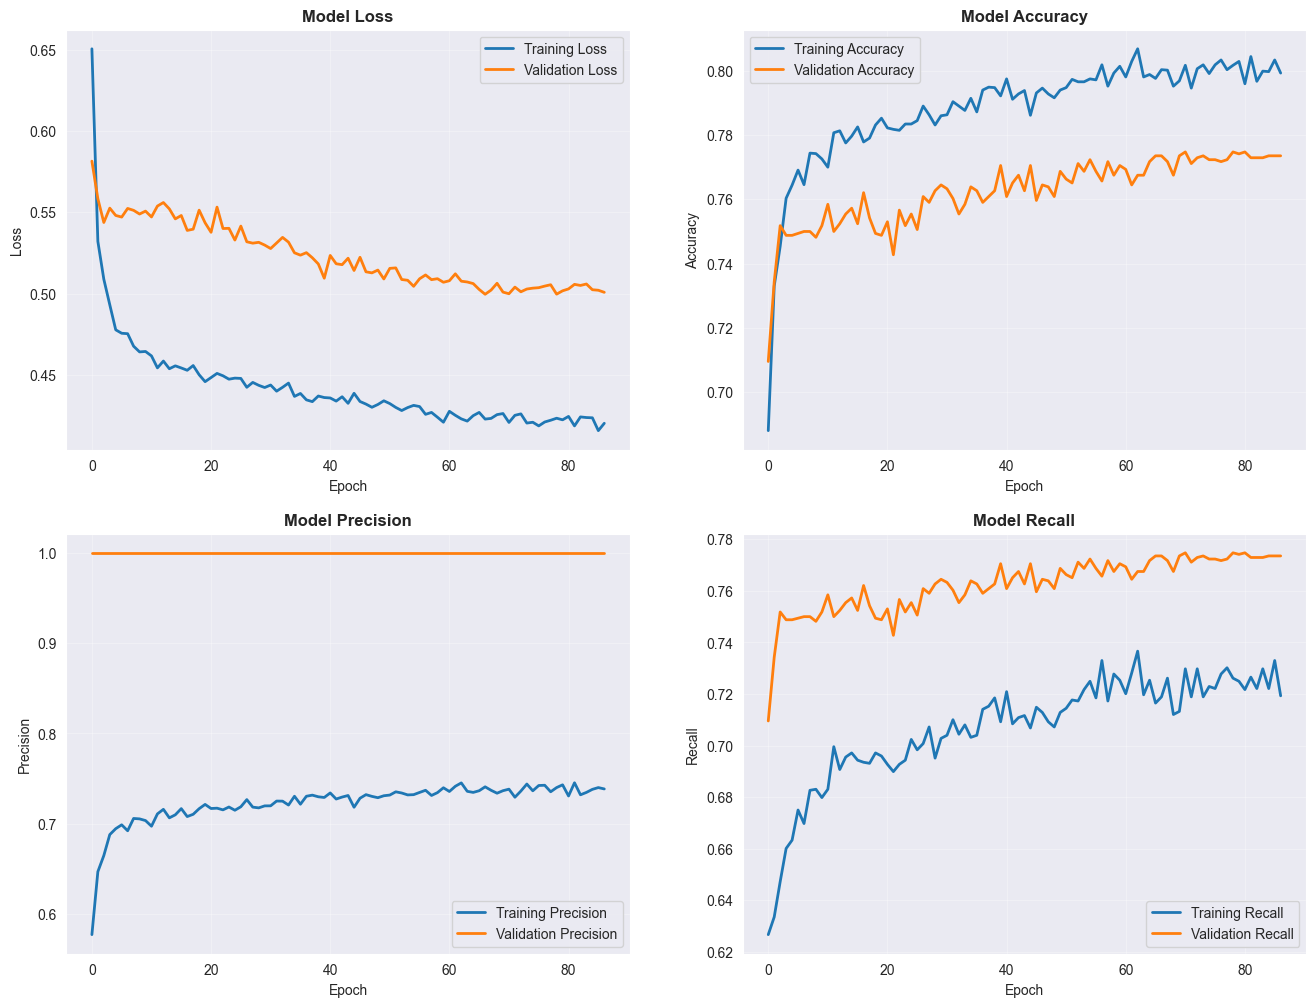

In [50]:
#visualization
print("Step 8: Creating visualizations")
print("="*60)

print("\n1. Training history plots:")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
#loss plot
axes[0, 0].plot(history_optimized.history['loss'], label='Training Loss', linewidth=2)
axes[0, 0].plot(history_optimized.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 0].set_title('Model Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch', fontsize=10)
axes[0, 0].set_ylabel('Loss', fontsize=10)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Accuracy plot
axes[0, 1].plot(history_optimized.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0, 1].plot(history_optimized.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0, 1].set_title('Model Accuracy', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch', fontsize=10)
axes[0, 1].set_ylabel('Accuracy', fontsize=10)
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Precision plot
axes[1, 0].plot(history_optimized.history['precision'], label='Training Precision', linewidth=2)
axes[1, 0].plot(history_optimized.history['val_precision'], label='Validation Precision', linewidth=2)
axes[1, 0].set_title('Model Precision', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch', fontsize=10)
axes[1, 0].set_ylabel('Precision', fontsize=10)
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Recall plot
axes[1, 1].plot(history_optimized.history['recall'], label='Training Recall', linewidth=2)
axes[1, 1].plot(history_optimized.history['val_recall'], label='Validation Recall', linewidth=2)
axes[1, 1].set_title('Model Recall', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch', fontsize=10)
axes[1, 1].set_ylabel('Recall', fontsize=10)
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.show()




2. Confusion matrix comparison


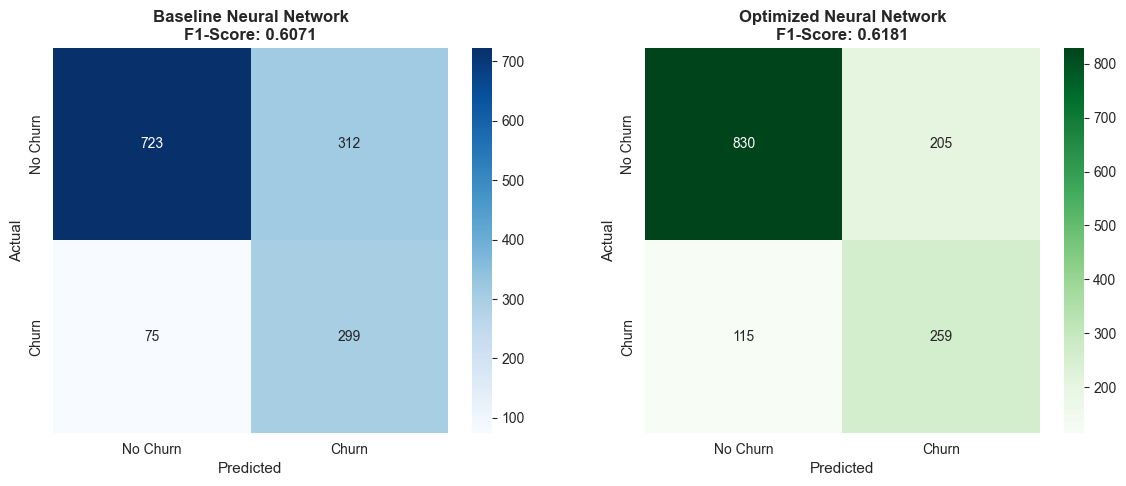

In [51]:
#confusion matrix comparison
print("\n2. Confusion matrix comparison")
fig, axes = plt.subplots(1,2,figsize=(14,5))
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
cm_optimized = confusion_matrix(y_test, y_pred_final)
# Baseline confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
axes[0].set_title(f'Baseline Neural Network\nF1-Score: {bs_f1:.4f}',
                  fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=11)
axes[0].set_xlabel('Predicted', fontsize=11)

# Optimized confusion matrix
sns.heatmap(cm_optimized, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
axes[1].set_title(f'Optimized Neural Network\nF1-Score: {final_f1:.4f}',
                  fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual', fontsize=11)
axes[1].set_xlabel('Predicted', fontsize=11)

plt.show()


3. Performance matrices comparison


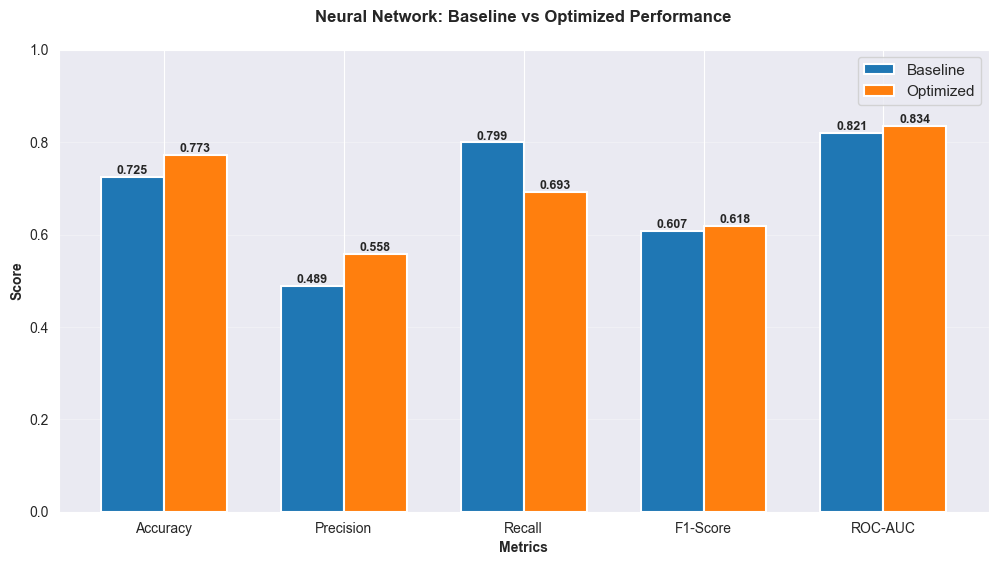

In [52]:
#perform matrices comparison
print("\n3. Performance matrices comparison")
fig, ax = plt.subplots(figsize=(12,6))

x = np.arange(len(comparison['Metric']))
width = 0.35

bars1 = ax.bar(x - width/2, comparison['Baseline'], width,
               label='Baseline', linewidth=1.5)
bars2 = ax.bar(x + width/2, comparison['Optimized'], width,
               label='Optimized',linewidth=1.5)

ax.set_xlabel('Metrics',fontweight='bold')
ax.set_ylabel('Score', fontweight='bold')
ax.set_title('Neural Network: Baseline vs Optimized Performance', fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(comparison['Metric'])
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.0])

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.show()




4. ROC curve


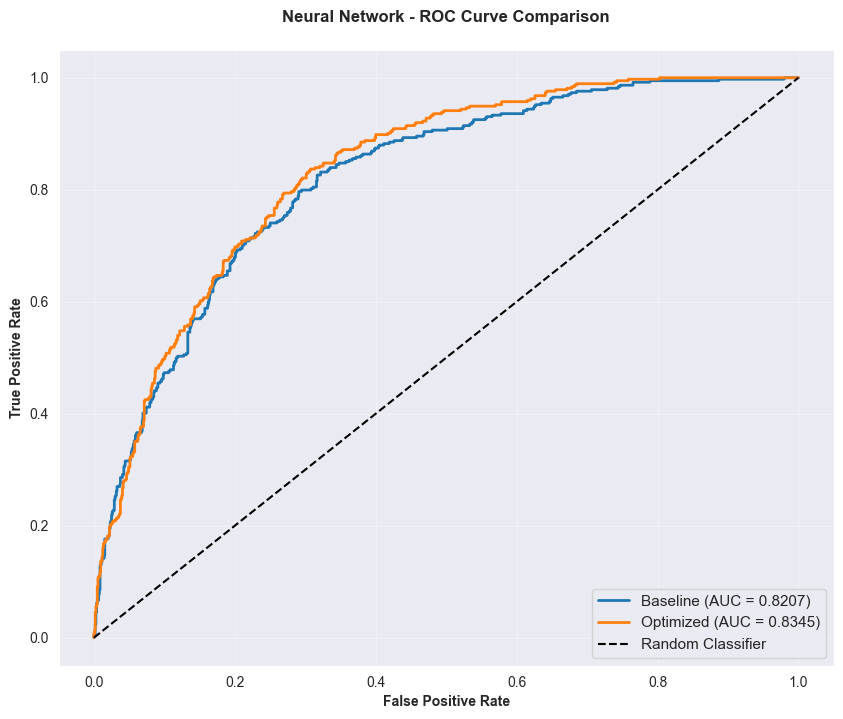

In [53]:
#ROC curve
print("\n4. ROC curve")
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_pred_prob_baseline)
fpr_optimized, tpr_optimized, _ = roc_curve(y_test, y_pred_proba_final)

plt.figure(figsize=(10, 8))
plt.plot(fpr_baseline, tpr_baseline, label=f'Baseline (AUC = {bs_roc_auc:.4f})',
         linewidth=2)
plt.plot(fpr_optimized, tpr_optimized, label=f'Optimized (AUC = {final_roc_auc:.4f})',
         linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1.5)

plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('Neural Network - ROC Curve Comparison', fontweight='bold', pad=20)
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)

plt.show()


5. Creating Precision-Recall curve...


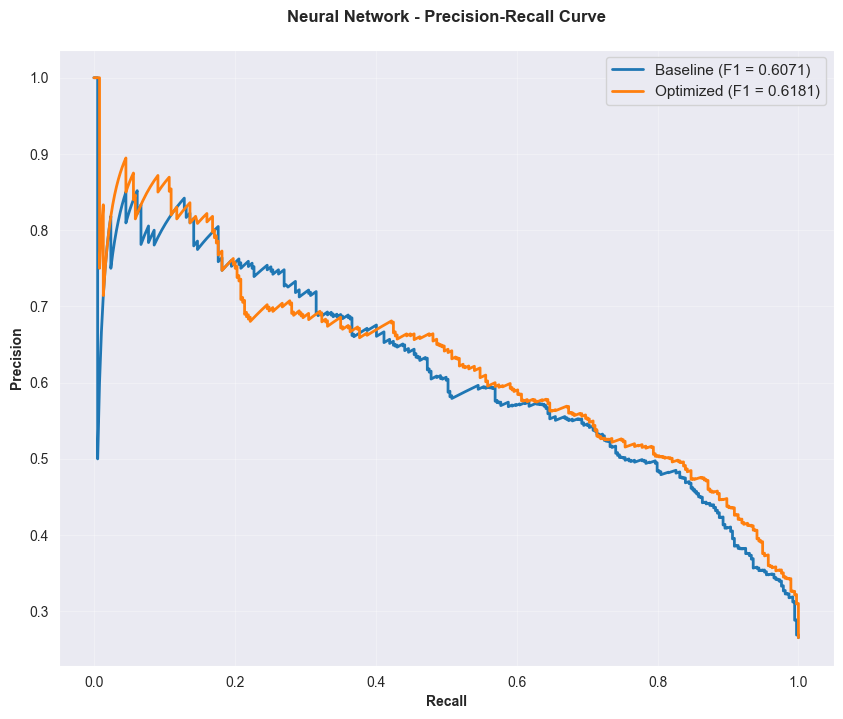

In [54]:
#Precision-recall curve
print("\n5. Creating Precision-Recall curve...")
precision_baseline, recall_baseline, _ = precision_recall_curve(y_test, y_pred_prob_baseline)
precision_optimized, recall_optimized, _ = precision_recall_curve(y_test, y_pred_proba_final)

plt.figure(figsize=(10, 8))
plt.plot(recall_baseline, precision_baseline,
         label=f'Baseline (F1 = {bs_f1:.4f})', linewidth=2)
plt.plot(recall_optimized, precision_optimized,
         label=f'Optimized (F1 = {final_f1:.4f})', linewidth=2)

plt.xlabel('Recall', fontweight='bold')
plt.ylabel('Precision',fontweight='bold')
plt.title('Neural Network - Precision-Recall Curve', fontweight='bold', pad=20)
plt.legend(loc='best', fontsize=11)
plt.grid(alpha=0.3)

plt.show()


6. Hyperparameter tuning results


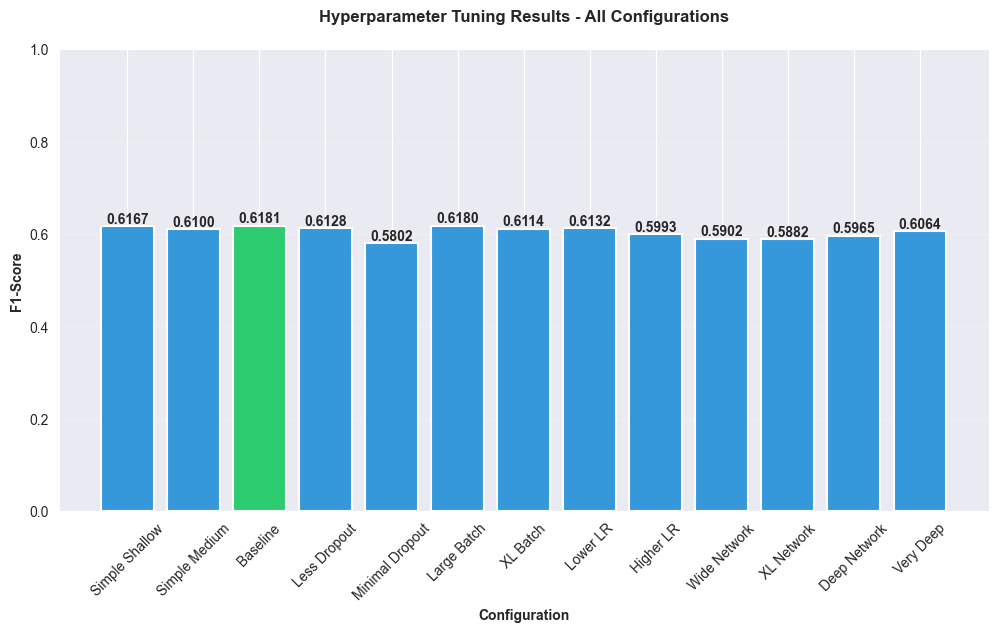

In [61]:
#hyperparameter tuning results
print("\n6. Hyperparameter tuning results")
plt.figure(figsize=(12, 6))

configs = [r['config'].replace('Config ', '').split(':')[0] for r in config_results]
f1_scores = [r['f1_score'] for r in config_results]

colors = ['#2ecc71' if score == max(f1_scores) else '#3498db' for score in f1_scores]

bars = plt.bar(configs, f1_scores, color=colors,linewidth=1.5)
plt.xlabel('Configuration', fontweight='bold')
plt.ylabel('F1-Score', fontweight='bold')
plt.title('Hyperparameter Tuning Results - All Configurations', fontweight='bold', pad=20)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.ylim([0, 1.0])

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')


plt.show()


In [62]:
#save model
print("Step 9: Save trained model")
print("="*60)

# Save the optimized model
nn_optimized.save('models/neural_network_model.keras')
print("Optimized Neural Network model saved to: models/neural_network_model.keras")

# Save model architecture as JSON
model_json = nn_optimized.to_json()
with open('models/neural_network_architecture.json', 'w') as json_file:
    json_file.write(model_json)
print("Model architecture saved to: models/neural_network_architecture.json")

#Save all results
results = {
    'baseline': {
        'accuracy': bs_accuracy,
        'precision': bs_precision,
        'recall': bs_recall,
        'f1_score': bs_f1,
        'roc_auc': bs_roc_auc,
        'confusion_matrix': cm,
        'history': history_baseline.history
    },
    'optimized': {
        'accuracy': final_accuracy,
        'precision': final_precision,
        'recall': final_recall,
        'f1_score': final_f1,
        'roc_auc': final_roc_auc,
        'confusion_matrix': cm_optimized,
        'best_config': best_config,
        'history': history_optimized.history
    },
    'all_configs': config_results
}

with open('models/neural_network_results.pkl', 'wb') as f:
    pickle.dump(results, f)

print("All results saved to: models/neural_network_results.pkl")



Step 9: Save trained model
Optimized Neural Network model saved to: models/neural_network_model.keras
Model architecture saved to: models/neural_network_architecture.json
All results saved to: models/neural_network_results.pkl


In [63]:
#summary report
print("Step 10: Summary report")
print("=" * 60)

summary_report = f"""
NEURAL NETWORK CLASSIFIER - SUMMARY REPORT
==========================================
Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

DATASET INFORMATION
-------------------
Training samples: {X_train.shape[0]}
Test samples: {X_test.shape[0]}
Number of features: {X_train.shape[1]}
Class distribution (test): {np.bincount(y_test)}

NEURAL NETWORK ARCHITECTURE
----------------------------
Framework: TensorFlow/Keras {tf.__version__}
Input dimension: {input_dimension}

Baseline Configuration:
  - Hidden layers: [64, 32]
  - Dropout rate: 0.3
  - Learning rate: 0.001
  - Batch size: 32

HYPERPARAMETER TUNING
---------------------
Configurations tested: {len(configs)}

Best Configuration:
  - Name: {best_config['name']}
  - Hidden layers: {best_config['layers']}
  - Dropout rate: {best_config['dropout']}
  - Learning rate: {best_config['lr']}
  - Batch size: {best_config['batch_size']}
"""

print(summary_report)
with open('results/neural_network_model_summary.txt', 'w') as f:
    f.write(summary_report)
print("\nSummary report saved to: results/neural_network_model_summary.txt")

Step 10: Summary report

NEURAL NETWORK CLASSIFIER - SUMMARY REPORT
Generated: 2025-12-12 11:28:22

DATASET INFORMATION
-------------------
Training samples: 8278
Test samples: 1409
Number of features: 19
Class distribution (test): [1035  374]

NEURAL NETWORK ARCHITECTURE
----------------------------
Framework: TensorFlow/Keras 2.20.0
Input dimension: 19

Baseline Configuration:
  - Hidden layers: [64, 32]
  - Dropout rate: 0.3
  - Learning rate: 0.001
  - Batch size: 32

HYPERPARAMETER TUNING
---------------------
Configurations tested: 13

Best Configuration:
  - Name: Baseline
  - Hidden layers: [64, 32]
  - Dropout rate: 0.3
  - Learning rate: 0.001
  - Batch size: 32


Summary report saved to: results/neural_network_model_summary.txt
